# Pubtator Central Update

Pubtator Central updates their data monthly; however, they changed their data to be xml format instead of common text.
Based on this update it is imperative to know what changes have been made/format this data to make future experiments easier to work with.
This notebook is being created to make training word2vec a whole lot easier.

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, Counter
import csv
from datetime import datetime
import itertools
import lzma
from pathlib import Path
import pickle
import tarfile

import lxml.etree as ET
import numpy as np
import pandas as pd
import plotnine as p9
import tqdm

from biovectors_modules.word2vec_run_helper import (
    PubMedSentencesIterator,
    PubtatorTarIterator,
    chunks,
)

# Look at xml example

Lets look at an example entry for each tagged document. Looks like it is regular BioCXML format which is good for processing.

In [2]:
# Move up a level in the repository, enter the folder with all the pubmed abstracts
# grab all files with the .gz extenstion for processing
pubtator_abstract_batch = list(Path("../pubtator_abstracts").rglob("*.gz"))
print(len(pubtator_abstract_batch))

10


In [3]:
for batch_directory in pubtator_abstract_batch:
    for doc_obj in PubtatorTarIterator(batch_directory, return_ibatch_file=False):
        passages = doc_obj.xpath("//passage")
        lxml_str = ET.tostring(passages[1], pretty_print=True)
        print(lxml_str.decode("utf-8"))
        break
    break

<passage>
  <infon key="section_type">ABSTRACT</infon>
  <infon key="type">abstract</infon>
  <offset>127</offset>
  <text>CuA is a dinuclear mixed-valence center located in subunit 2 of the ba3 type cytochrome oxidase from Thermus thermophilus. The assembly of this site within the periplasmic membrane is believed to be mediated by the copper chaperones Sco and/or PCuAC, but the biological mechanisms are still poorly understood, thereby stimulating interest in the mechanisms of CuA formation from inorganic ions. The formulation of the CuA center as an electron-delocalized Cu1.5 - Cu1.5 system, implicates both Cu(II) and Cu(I) states in the metalation process. In earlier work we showed that selenomethionine (SeM) substitution of the coordinated M160 residue provided a ligand-directed probe for studying the copper coordination environment via the Se XAS signal, which was particularly useful for interrogating the Cu(I) states where other spectroscopic probes are absent. In the present stu

# Grab Document Metadata

In [4]:
if not Path("output/pmc_metadata.tsv.xz").exists():
    with lzma.open("output/pmc_metadata.tsv.xz", "wt") as outfile:
        writer = csv.DictWriter(
            outfile,
            fieldnames=[
                "batch_folder",
                "batch_file",
                "doc_id",
                "doi",
                "pmc",
                "pmid",
                "section",
                "published_year",
            ],
            delimiter="\t",
        )
        writer.writeheader()

        # Cycle through each batch file
        for batch_directory in pubtator_abstract_batch:

            # Cycle through each document
            for file_name, doc_obj in tqdm.tqdm(
                PubtatorTarIterator(batch_directory, return_ibatch_file=True)
            ):
                doc_id = doc_obj.xpath("id/text()")
                doi = doc_obj.xpath("passage/infon[@key='article-id_doi']/text()")
                pmc_id = doc_obj.xpath("passage/infon[@key='article-id_pmc']/text()")
                pmid = doc_obj.xpath("passage/infon[@key='article-id_pmid']/text()")
                sections = doc_obj.xpath("passage/infon[@key='section_type']/text()")
                section_type = doc_obj.xpath("passage/infon[@key='type']/text()")
                year = doc_obj.xpath("passage/infon[@key='year']/text()")

                section_headers = "|".join(sorted(list(set(sections))))
                section_headers_type = "|".join(
                    sorted(list(set(map(lambda x: x.upper(), section_type))))
                )

                writer.writerow(
                    {
                        "batch_folder": batch_directory.name,
                        "batch_file": file_name,
                        "doc_id": doc_id[0],
                        "doi": doi[0] if len(doi) > 0 else "",
                        "pmc": pmc_id[0] if len(pmc_id) > 0 else "",
                        "pmid": pmid[0] if len(pmid) > 0 else "",
                        "section": section_headers
                        if len(section_headers) > 0
                        else section_headers_type,
                        "published_year": year[0]
                        if len(year) > 0
                        else 0,  # Shouldnt get to the else statement
                    }
                )

# Analyze Abstract/Full Text Dataset

In [5]:
pubtator_central_metadata_df = pd.read_csv("output/pmc_metadata_2.tsv.xz", sep="\t")
print(pubtator_central_metadata_df.shape)
pubtator_central_metadata_df.head()

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3156: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.


(30697637, 8)


,batch_folder,batch_file,doc_id,doi,pmc,pmid,section,published_year
0,BioCXML.3.gz,output/BioCXML/10003.bioc.xml,3616644,10.1021/ja307276z,3616644,22946616.0,ABSTRACT|DISCUSS|FIG|INTRO|METHODS|REF|RESULTS...,2012
1,BioCXML.3.gz,output/BioCXML/10003.bioc.xml,3616678,10.1097/ADT.0b013e31815c2ded,3616678,23565053.0,ABSTRACT|DISCUSS|INTRO|METHODS|REF|RESULTS|TAB...,2008
2,BioCXML.3.gz,output/BioCXML/10003.bioc.xml,3616697,10.1093/nar/gkt072,3616697,23396444.0,ABSTRACT|ACK_FUND|CONCL|FIG|INTRO|METHODS|REF|...,2013
3,BioCXML.3.gz,output/BioCXML/10003.bioc.xml,3616698,10.1093/nar/gkt006,3616698,23335781.0,ABSTRACT|ACK_FUND|DISCUSS|FIG|INTRO|METHODS|RE...,2013
4,BioCXML.3.gz,output/BioCXML/10003.bioc.xml,3616699,10.1093/nar/gkt030,3616699,23393190.0,ABSTRACT|ACK_FUND|DISCUSS|FIG|INTRO|METHODS|RE...,2013


## Sanity Check the data

In [6]:
# Sanity check that all documents have a published year
(pubtator_central_metadata_df.query("published_year.isnull()").shape)

(0, 8)

In [7]:
# Do all documents have an id?
(pubtator_central_metadata_df.query("doc_id.isnull()").shape)

(0, 8)

In [8]:
# Do all documents have a pmid?
(pubtator_central_metadata_df.query("pmid.isnull()").shape)

(27244927, 8)

In [9]:
# Do all documents have a pmc id?
(pubtator_central_metadata_df.query("pmc.isnull()").shape)

(24449017, 8)

In [10]:
# Do all documents have a doi?
(pubtator_central_metadata_df.query("doi.isnull()").shape)

(27517661, 8)

## Published Year Distribution

In [11]:
(pubtator_central_metadata_df.sort_values("published_year").published_year.unique())

array([   0, 1781, 1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790,
       1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800, 1801,
       1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811, 1812,
       1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822, 1823,
       1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833, 1834,
       1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844, 1845,
       1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855, 1856,
       1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867,
       1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878,
       1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889,
       1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900,
       1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911,
       1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922,
       1923, 1924, 1925, 1926, 1927, 1928, 1929, 19

In [12]:
doc_count_df = (
    pubtator_central_metadata_df.groupby("published_year")
    .agg({"published_year": "size"})
    .rename(index=str, columns={"published_year": "doc_count"})
    .reset_index()
    .astype({"published_year": int, "doc_count": int})
)
doc_count_df.head()

,published_year,doc_count
0,0,43010
1,1781,68
2,1782,22
3,1783,26
4,1784,31


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/pre_1950_doc_count.png


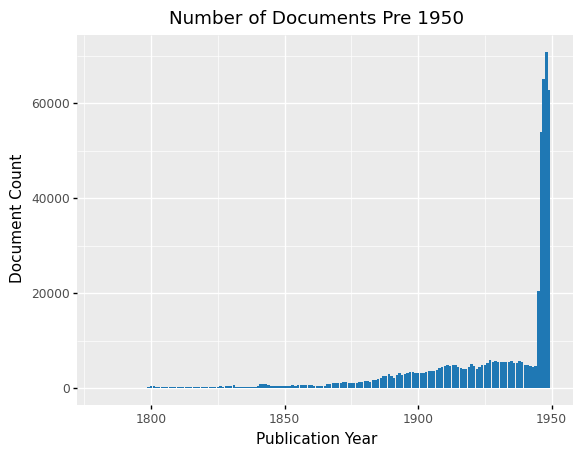

<ggplot: (-9223363278789655608)>


In [13]:
g = (
    p9.ggplot(
        doc_count_df.query("published_year > 0& published_year < 1950"),
        p9.aes(x="published_year", y="doc_count"),
    )
    + p9.geom_col(position=p9.position_dodge(width=0.9), fill="#1f78b4")
    + p9.labs(
        title="Number of Documents Pre 1950", x="Publication Year", y="Document Count"
    )
)
g.save("output/figures/pre_1950_doc_count.png", dpi=500)
print(g)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/post_1950_doc_count.png


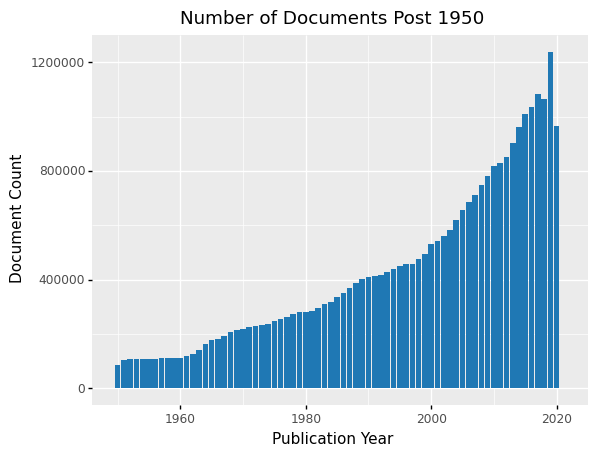

<ggplot: (-9223363278789786301)>


In [14]:
g = (
    p9.ggplot(
        doc_count_df.query("published_year >= 1950"),
        p9.aes(x="published_year", y="doc_count"),
    )
    + p9.geom_col(position=p9.position_dodge(width=0.9), fill="#1f78b4")
    + p9.labs(
        title="Number of Documents Post 1950", x="Publication Year", y="Document Count"
    )
)
g.save("output/figures/post_1950_doc_count.png", dpi=500)
print(g)

In [15]:
full_text_doc_count_df = (
    pubtator_central_metadata_df[
        pubtator_central_metadata_df.apply(lambda x: "INTRO" in x.section, axis=1)
    ]
    .groupby("published_year")
    .agg({"published_year": "size"})
    .rename(index=str, columns={"published_year": "doc_count"})
    .reset_index()
    .astype({"published_year": int, "doc_count": int})
)
full_text_doc_count_df.head()

,published_year,doc_count
0,1955,1
1,1956,1
2,1959,23
3,1960,55
4,1961,55


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/pre_2000_full_text_doc_count.png


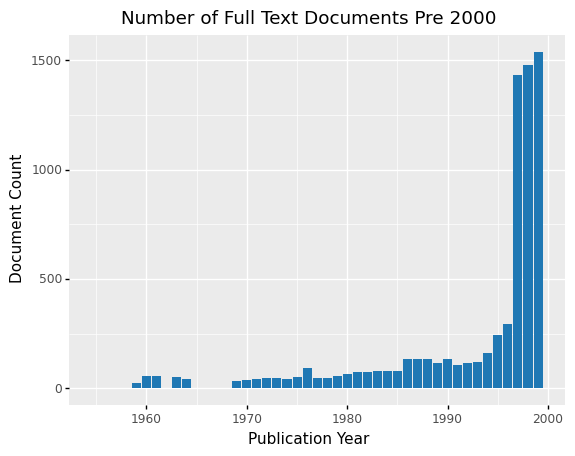

<ggplot: (-9223363278782533190)>


In [16]:
g = (
    p9.ggplot(
        full_text_doc_count_df.query("published_year > 0& published_year < 2000"),
        p9.aes(x="published_year", y="doc_count"),
    )
    + p9.geom_col(position=p9.position_dodge(width=0.9), fill="#1f78b4")
    + p9.labs(
        title="Number of Full Text Documents Pre 2000",
        x="Publication Year",
        y="Document Count",
    )
)
g.save("output/figures/pre_2000_full_text_doc_count.png", dpi=500)
print(g)

/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/post_1950_full_text_doc_count.png


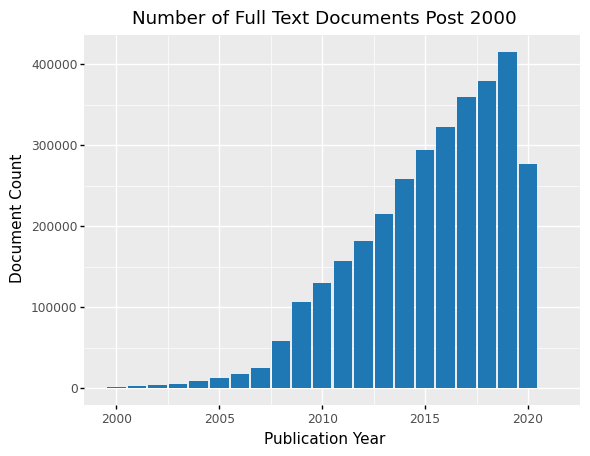

<ggplot: (-9223363278789798428)>


In [17]:
g = (
    p9.ggplot(
        full_text_doc_count_df.query("published_year >= 2000"),
        p9.aes(x="published_year", y="doc_count"),
    )
    + p9.geom_col(position=p9.position_dodge(width=0.9), fill="#1f78b4")
    + p9.labs(
        title="Number of Full Text Documents Post 2000",
        x="Publication Year",
        y="Document Count",
    )
)
g.save("output/figures/post_2000_full_text_doc_count.png", dpi=500)
print(g)

# Shared Tokens Across Time - Abstract Only

In [15]:
tokens_by_year = defaultdict(Counter)
sentence_iterator = PubMedSentencesIterator(
    pubtator_abstract_batch,
    year_filter=list(range(1990, datetime.now().year + 1, 1)),
    return_year=True,
    tag_entities=False,
    jobs=3,
)

In [16]:
if not Path("output/unique_tokens_by_year_replace.pkl").exists():
    for year, sentence in tqdm.tqdm(sentence_iterator):
        tokens_by_year[year].update(Counter(sentence))

4385560it [1:30:36, 126.82it/s] 

Parsing the archive reached an error. Breaking out the loop


15051965it [5:25:41, 770.25it/s] 


In [17]:
if not Path("output/unique_tokens_by_year_replace.pkl").exists():
    pickle.dump(tokens_by_year, open("output/unique_tokens_by_year_replace.pkl", "wb"))
else:
    tokens_by_year = pickle.load(open("output/unique_tokens_by_year_replace.pkl", "rb"))

## Unique Tokens Available per Year

In [18]:
data_rows = []

for query_year in tokens_by_year:

    data_rows.append(
        {
            "year": query_year,
            "num_tokens": len(tokens_by_year[query_year]),
        }
    )

In [19]:
unique_token_df = pd.DataFrame.from_records(data_rows)
unique_token_df

,year,num_tokens
0,2007,119790
1,2001,42661
2,2002,46577
3,1995,30358
4,2009,283537
5,2008,201942
6,2010,327784
7,2013,466437
8,2012,418607
9,2014,530873


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/post_1990_unique_tokens_abstracts.png


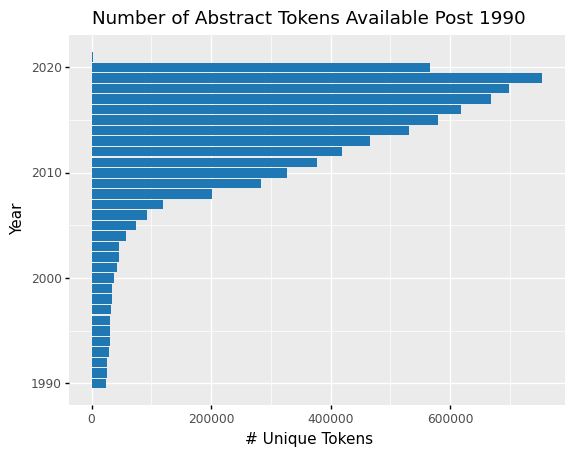

<ggplot: (-9223363247278316407)>


In [20]:
g = (
    p9.ggplot(unique_token_df, p9.aes(x="year", y="num_tokens"))
    + p9.geom_col(fill="#1f78b4")
    + p9.coord_flip()
    + p9.labs(
        title="Number of Abstract Tokens Available Post 1990",
        x="Year",
        y="# Unique Tokens",
    )
)
g.save("output/figures/post_1990_unique_tokens_abstracts.png", dpi=500)
print(g)

## Shared tokens across years

In [21]:
data_rows = []
reversed_tokens = list(sorted(tokens_by_year.keys()))[::-1]
all_tokens = set(tokens_by_year[2021].keys()) | set(tokens_by_year[2020].keys())

for query_year in reversed_tokens[1:]:
    query_year_vocab_set = set(tokens_by_year[query_year].keys())
    tokens_matched = all_tokens & query_year_vocab_set

    data_rows.append(
        {
            "years": str(query_year) if query_year != 2020 else "2020-21",
            "percentage_tokens_mapped": len(tokens_matched) / len(all_tokens),
            "num_tokens_matched": len(tokens_matched),
            "num_tokens_total": len(all_tokens),
        }
    )

In [22]:
token_overlap_df = pd.DataFrame.from_dict(data_rows)
token_overlap_df

,years,percentage_tokens_mapped,num_tokens_matched,num_tokens_total
0,2020-21,0.999891,566286,566348
1,2019,0.482059,273013,566348
2,2018,0.464188,262892,566348
3,2017,0.450832,255328,566348
4,2016,0.431023,244109,566348
5,2015,0.414335,234658,566348
6,2014,0.394436,223388,566348
7,2013,0.366402,207511,566348
8,2012,0.339016,192001,566348
9,2011,0.315327,178585,566348


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/tokens_overlap_with_2020-21_abstracts.png


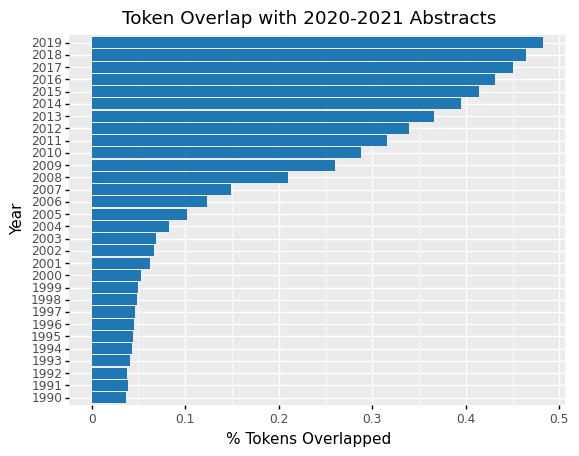

<ggplot: (-9223363247205604541)>


In [23]:
g = (
    p9.ggplot(
        token_overlap_df.iloc[1:, :], p9.aes(x="years", y="percentage_tokens_mapped")
    )
    + p9.geom_col(fill="#1f78b4")
    + p9.coord_flip()
    + p9.labs(
        title="Token Overlap with 2020-2021 Abstracts",
        x="Year",
        y="Fraction of Tokens Overlapped",
    )
)
g.save("output/figures/tokens_overlap_with_2020-21_abstracts.png", dpi=500)
print(g)

# Shared Tokens Across Time - Full Text Only

Grab sentences within the full text documents

In [24]:
tokens_by_year_full_text = defaultdict(Counter)
sentence_iterator = PubMedSentencesIterator(
    pubtator_abstract_batch,
    section_filter=["INTRO", "METHODS", "RESULTS", "DISCUSS", "CONCL", "SUPPL"],
    year_filter=list(range(1990, datetime.now().year + 1, 1)),
    return_year=True,
    tag_entities=False,
    jobs=3,
)

In [25]:
if not Path("output/unique_tokens_by_year_full_text_replace.pkl").exists():
    for year, sentence in tqdm.tqdm(sentence_iterator):
        tokens_by_year_full_text[year].update(Counter(sentence))

59230495it [6:41:04, 2331.03it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

62485959it [7:03:53, 2317.52it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

65802105it [7:25:39, 2625.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_m

121473596it [13:45:27, 2709.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

124452703it [14:04:54, 2271.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

124958150it [14:08:14, 2782.32it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.i

In [26]:
if not Path("output/unique_tokens_by_year_full_text_replace.pkl").exists():
    pickle.dump(
        tokens_by_year_full_text,
        open("output/unique_tokens_by_year_full_text_replace.pkl", "wb"),
    )
else:
    tokens_by_year_full_text = pickle.load(
        open("output/unique_tokens_by_year_full_text_replace.pkl", "rb")
    )

## Unique Tokens Available per Year

In [27]:
data_rows = []

for query_year in tokens_by_year_full_text:

    data_rows.append(
        {
            "year": query_year,
            "num_tokens": len(tokens_by_year_full_text[query_year]),
        }
    )

In [28]:
unique_token_full_text_df = pd.DataFrame.from_records(data_rows)
unique_token_full_text_df

,year,num_tokens
0,2013,3483872
1,2011,2789992
2,2008,1340025
3,2010,2383537
4,2012,3109171
5,2014,4000869
6,2007,724022
7,2006,525842
8,2009,2040215
9,2015,4413455


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/post_1990_unique_tokens_full_text.png


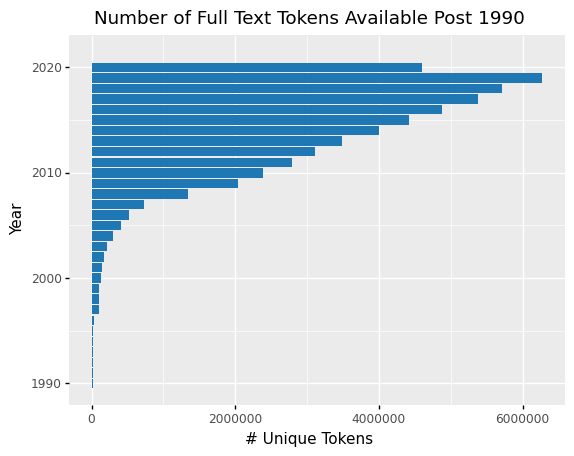

<ggplot: (-9223363247533580856)>


In [29]:
g = (
    p9.ggplot(unique_token_full_text_df, p9.aes(x="year", y="num_tokens"))
    + p9.geom_col(fill="#1f78b4")
    + p9.coord_flip()
    + p9.labs(
        title="Number of Full Text Tokens Available Post 1990",
        x="Year",
        y="# Unique Tokens",
    )
)
g.save("output/figures/post_1990_unique_tokens_full_text.png", dpi=500)
print(g)

## Shared tokens across years

In [30]:
data_rows = []
reversed_tokens = list(sorted(tokens_by_year_full_text.keys()))[::-1]
all_tokens = set(tokens_by_year_full_text[2021].keys()) | set(
    tokens_by_year_full_text[2020].keys()
)

for query_year in reversed_tokens[1:]:
    query_year_vocab_set = set(tokens_by_year_full_text[query_year].keys())
    tokens_matched = all_tokens & query_year_vocab_set

    data_rows.append(
        {
            "years": str(query_year) if query_year != 2020 else "2020-21",
            "percentage_tokens_mapped": len(tokens_matched) / len(all_tokens),
            "num_tokens_matched": len(tokens_matched),
            "num_tokens_total": len(all_tokens),
        }
    )

In [31]:
token_overlap_full_text_df = pd.DataFrame.from_dict(data_rows)
token_overlap_full_text_df

,years,percentage_tokens_mapped,num_tokens_matched,num_tokens_total
0,2020-21,0.999930,4604079,4604402
1,2019,0.398108,1833051,4604402
2,2018,0.377073,1736197,4604402
3,2017,0.359584,1655668,4604402
4,2016,0.335823,1546265,4604402
5,2015,0.314967,1450236,4604402
6,2014,0.294210,1354663,4604402
7,2013,0.268902,1238134,4604402
8,2012,0.246252,1133845,4604402
9,2011,0.227725,1048536,4604402


/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/danich1/anaconda3/envs/biovectors/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: output/figures/tokens_overlap_with_2020-21_full_text.png


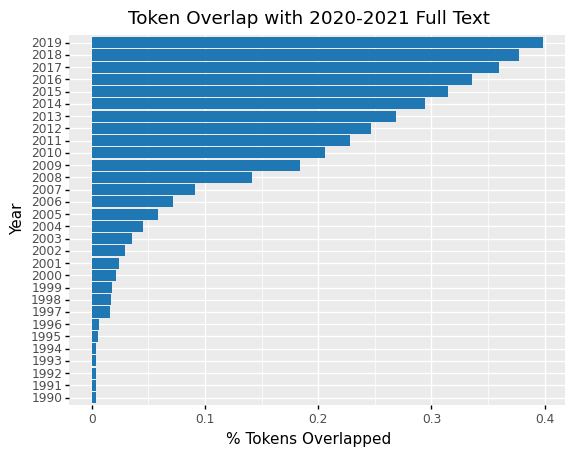

<ggplot: (8789573685424)>


In [32]:
g = (
    p9.ggplot(
        token_overlap_full_text_df.iloc[1:, :],
        p9.aes(x="years", y="percentage_tokens_mapped"),
    )
    + p9.geom_col(fill="#1f78b4")
    + p9.coord_flip()
    + p9.labs(
        title="Token Overlap with 2020-2021 Full Text",
        x="Year",
        y="Fraction of Tokens Overlapped",
    )
)
g.save("output/figures/tokens_overlap_with_2020-21_full_text.png", dpi=500)
print(g)